1. Самостоятельно разобраться с тем, что такое tfidf (документация https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html и еще - https://scikit-learn.org/stable/modules/feature_extraction.html#text-feature-extraction)

In [3]:
import pandas as pd
import numpy as np
import re

#from gensim.test.utils import common_texts
from gensim.corpora.dictionary import Dictionary

#предобработка текстов
from nltk.corpus import stopwords
#from nltk.tokenize import word_tokenize

from razdel import tokenize # https://github.com/natasha/razdel
#!pip install razdel

import pymorphy2  # pip install pymorphy2

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, roc_auc_score, precision_score, classification_report, \
                                precision_recall_curve, confusion_matrix
import itertools

import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
# новости
news = pd.read_csv("materials.csv")
print(news.shape)
news.head(3)

(27000, 2)


,doc_id,title
0,6,Заместитель председателяnправительства РФnСерг...
1,4896,Матч 1/16 финала Кубка России по футболу был п...
2,4897,Форвард «Авангарда» Томаш Заборский прокоммент...


In [5]:
# Загрузим пользователей и списки последних прочитанных новостей
users = pd.read_csv("users_articles.csv")
users.head(3)

,uid,articles
0,u105138,"[293672, 293328, 293001, 293622, 293126, 1852]"
1,u108690,"[3405, 1739, 2972, 1158, 1599, 322665]"
2,u108339,"[1845, 2009, 2356, 1424, 2939, 323389]"


In [7]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/maksim/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [8]:
stopword_ru = stopwords.words('russian')
len(stopword_ru)

morph = pymorphy2.MorphAnalyzer()

In [9]:
stopword_ru = stopwords.words('russian')
len(stopword_ru)

morph = pymorphy2.MorphAnalyzer()

In [10]:
with open('stopwords.txt') as f:
    additional_stopwords = [w.strip() for w in f.readlines() if w]
stopword_ru += additional_stopwords
len(stopword_ru)

776

In [11]:
def clean_text(text):
    '''
    очистка текста
    
    на выходе очищеный текст
    
    '''
    if not isinstance(text, str):
        text = str(text)
    
    text = text.lower()
    text = text.strip('\n').strip('\r').strip('\t')
    text = re.sub("-\s\r\n\|-\s\r\n|\r\n", '', str(text))

    text = re.sub("[0-9]|[-—.,:;_%©«»?*!@#№$^•·&()]|[+=]|[[]|[]]|[/]|", '', text)
    text = re.sub(r"\r\n\t|\n|\\s|\r\t|\\n", ' ', text)
    text = re.sub(r'[\xad]|[\s+]', ' ', text.strip())
    
    #tokens = list(tokenize(text))
    #words = [_.text for _ in tokens]
    #words = [w for w in words if w not in stopword_ru]
    
    #return " ".join(words)
    return text

cache = {}

def lemmatization(text):
    '''
    лемматизация
        [0] если зашел тип не `str` делаем его `str`
        [1] токенизация предложения через razdel
        [2] проверка есть ли в начале слова '-'
        [3] проверка токена с одного символа
        [4] проверка есть ли данное слово в кэше
        [5] лемматизация слова
        [6] проверка на стоп-слова

    на выходе лист отлемматизированых токенов
    '''

    # [0]
    if not isinstance(text, str):
        text = str(text)
    
    # [1]
    tokens = list(tokenize(text))
    words = [_.text for _ in tokens]

    words_lem = []
    for w in words:
        if w[0] == '-': # [2]
            w = w[1:]
        if len(w)>1: # [3]
            if w in cache: # [4]
                words_lem.append(cache[w])
            else: # [5]
                temp_cach = cache[w] = morph.parse(w)[0].normal_form
                words_lem.append(temp_cach)
    
    words_lem_without_stopwords=[i for i in words_lem if not i in stopword_ru] # [6]
    
    return words_lem_without_stopwords

In [12]:
%%time
news['title'] = news['title'].apply(lambda x: clean_text(x), 1)

/var/folders/r0/bf13jj710857v4v0ckcfb8vc0000gp/T/ipykernel_96123/2296537027.py:15: FutureWarning: Possible nested set at position 39
  text = re.sub("[0-9]|[-—.,:;_%©«»?*!@#№$^•·&()]|[+=]|[[]|[]]|[/]|", '', text)


CPU times: user 27 s, sys: 828 ms, total: 27.8 s
Wall time: 28.8 s


In [13]:
%%time
news['title'] = news['title'].apply(lambda x: lemmatization(x), 1)

CPU times: user 3min 22s, sys: 596 ms, total: 3min 22s
Wall time: 3min 23s


In [14]:
texts = [t for t in news['title'].values]

common_dictionary = Dictionary(texts)
common_corpus = [common_dictionary.doc2bow(text) for text in texts]

In [15]:
common_dictionary[10]

'ватутин'

In [16]:
%%time
from gensim.models import LdaModel
lda = LdaModel(common_corpus, num_topics=25, id2word=common_dictionary)#, passes=10)

CPU times: user 1min 26s, sys: 2.49 s, total: 1min 28s
Wall time: 35.7 s


In [17]:
from gensim.test.utils import datapath

temp_file = datapath("model.lda")
lda.save(temp_file)

lda = LdaModel.load(temp_file)

In [18]:
other_texts = [t for t in news['title'].iloc[:3]]
other_corpus = [common_dictionary.doc2bow(text) for text in other_texts]

unseen_doc = other_corpus[2]
print(other_texts[2])
lda[unseen_doc]

['форвард', 'авангард', 'томаш', 'заборский', 'прокомментировать', 'игра', 'команда', 'матч', 'чемпионат', 'кхл', 'против', 'атланта', 'nnnn', 'плохой', 'матч', 'нижний', 'новгород', 'против', 'торпедо', 'настраиваться', 'первый', 'минута', 'включиться', 'заборский', 'получиться', 'забросить', 'быстрый', 'гол', 'задать', 'хороший', 'темп', 'поединок', 'играть', 'хороший', 'сторона', 'пять', 'очко', 'выезд', 'девять', 'хороший']


[(9, 0.29881236), (18, 0.18168102), (23, 0.4963495)]

In [19]:
x=lda.show_topics(num_topics=25, num_words=7,formatted=False)
topics_words = [(tp[0], [wd[0] for wd in tp[1]]) for tp in x]

for topic,words in topics_words:
    print("topic_{}: ".format(topic)+" ".join(words))

topic_0: операция всё врач кровь очень рост организм
topic_1: станция проект программа место открытие памятник тыс
topic_2: гражданин россиянин товар ссср фронт народный экономика
topic_3: министерство метод норма статья фон писать температура
topic_4: площадь выяснить участок авария двигатель рейтинг белоруссия
topic_5: мозг млн британский конкурс великобритания супруг выдать
topic_6: сша фонд население санкция россия рост регион
topic_7: ребёнок женщина семья общество возраст школа писать
topic_8: употребление балтийский мотив проба дания кг пищевой
topic_9: новый млрд проект россия украина украинский решение
topic_10: эксперт земля экономика всё цена большой болезнь
topic_11: снижение пенсия связанный лаборатория законодательство больной сектор
topic_12: торговый тыс территория террорист уничтожить экипаж боевик
topic_13: километр парламент законопроект южный корея остаток ученик
topic_14: рубль тыс продукция следствие ставка выплата уголовный
topic_15: банк убийство nn обвинение аэ

In [20]:
def get_lda_vector(text):
    unseen_doc = common_dictionary.doc2bow(text)
    lda_tuple = lda[unseen_doc]
    not_null_topics = dict(zip([i[0] for i in lda_tuple], [i[1] for i in lda_tuple]))

    output_vector = []
    for i in range(25):
        if i not in not_null_topics:
            output_vector.append(0)
        else:
            output_vector.append(not_null_topics[i])
    return np.array(output_vector)

In [21]:
topic_matrix = pd.DataFrame([get_lda_vector(text) for text in news['title'].values])
topic_matrix.columns = ['topic_{}'.format(i) for i in range(25)]
topic_matrix['doc_id'] = news['doc_id'].values
topic_matrix = topic_matrix[['doc_id']+['topic_{}'.format(i) for i in range(25)]]
topic_matrix.head(5)

,doc_id,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.268051,0.0,0.0,0.000000,0.0,0.627757,0.000000,0.0,0.081722,0.0
1,4896,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.631964,0.0,0.293978,0.0
2,4897,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.181809,0.0,0.000000,0.000000,0.0,0.496331,0.0
3,4898,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.452677,0.0,0.000000,0.000000,0.0,0.196910,0.0
4,4899,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.0,0.421412,0.000000,0.0,0.145535,0.0


### Векторные представления 

In [22]:
users.head(3)

,uid,articles
0,u105138,"[293672, 293328, 293001, 293622, 293126, 1852]"
1,u108690,"[3405, 1739, 2972, 1158, 1599, 322665]"
2,u108339,"[1845, 2009, 2356, 1424, 2939, 323389]"


In [23]:
doc_dict = dict(zip(topic_matrix['doc_id'].values, topic_matrix[['topic_{}'.format(i) for i in range(25)]].values))

In [24]:
doc_dict[293622]

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.0368885 , 0.16215651, 0.05946055, 0.        , 0.        ,
       0.        , 0.04009359, 0.        , 0.02028965, 0.        ,
       0.0386576 , 0.        , 0.        , 0.3016524 , 0.        ,
       0.15807228, 0.        , 0.        , 0.17186499, 0.        ])

In [25]:
user_articles_list = users['articles'].iloc[33]

In [26]:
def get_user_embedding(user_articles_list):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    user_vector = np.mean(user_vector, 0)
    return user_vector

In [27]:
get_user_embedding(user_articles_list)

array([0.05665729, 0.00224917, 0.01078595, 0.03724144, 0.01029484,
       0.        , 0.09819493, 0.02811827, 0.        , 0.10426774,
       0.00447122, 0.01970714, 0.00259584, 0.        , 0.05380414,
       0.07096186, 0.        , 0.0134541 , 0.06013943, 0.00640809,
       0.26711209, 0.05814405, 0.00215602, 0.00331975, 0.07793733])

In [28]:
users['articles'].iloc[33]

'[323329, 321961, 324743, 323186, 324632, 474690]'

In [29]:
" ".join(news[news['doc_id']==323186]['title'].iloc[0])

'глава российский мид сергей лавров опровергнуть появиться сми информация якобы готовиться обмен декларация россия сша сотрудничество сфера риа новость nn читать сообщение разговаривать автор сообщение откуда автор источник какихлибо основание подобный род репортаж откуда информация появиться журналист итог встреча госсекретарь сша джон керри nn позиция изложить декларация напринимать достаточно рамка обсе рамка совет россия нато высокий уровень продекларировать всё обеспечивать неделимость безопасность никто обеспечивать безопасность счёт безопасность продолжить министр лавров москва система нато создавать проблема безопасность поэтому декларация недостаточно договариваться совместный система россия предлагать начинать путин посещать сша нужно вести речь очередной декларация гарантия проверять объективный военнотехнический критерий гарантия ненаправленность система против российский ядерный потенциал подчеркнуть глава мид газета коммерсантъ ссылаться дипломатический источник написать 

In [30]:
user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding(x), 1)])
user_embeddings.columns = ['topic_{}'.format(i) for i in range(25)]
user_embeddings['uid'] = users['uid'].values
user_embeddings = user_embeddings[['uid']+['topic_{}'.format(i) for i in range(25)]]
user_embeddings.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,u105138,0.006656,0.070454,0.020956,0.000000,0.015990,0.006148,0.069800,0.037843,0.025384,...,0.018935,0.000000,0.000000,0.091548,0.0,0.121058,0.060152,0.0,0.067654,0.122558
1,u108690,0.042619,0.002271,0.009758,0.033450,0.000000,0.003069,0.096052,0.025262,0.003711,...,0.060587,0.000000,0.002172,0.109275,0.0,0.140997,0.126445,0.0,0.007425,0.081364
2,u108339,0.109930,0.031603,0.010276,0.016823,0.011163,0.006879,0.045619,0.010593,0.000000,...,0.072877,0.001685,0.006118,0.020492,0.0,0.149321,0.190859,0.0,0.010216,0.098991


In [31]:
target = pd.read_csv("users_churn.csv")
target.head(3)

,uid,churn
0,u107120,0
1,u102277,0
2,u102444,0


In [32]:
X = pd.merge(user_embeddings, target, 'left')
X.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24,churn
0,u105138,0.006656,0.070454,0.020956,0.000000,0.015990,0.006148,0.069800,0.037843,0.025384,...,0.000000,0.000000,0.091548,0.0,0.121058,0.060152,0.0,0.067654,0.122558,0
1,u108690,0.042619,0.002271,0.009758,0.033450,0.000000,0.003069,0.096052,0.025262,0.003711,...,0.000000,0.002172,0.109275,0.0,0.140997,0.126445,0.0,0.007425,0.081364,1
2,u108339,0.109930,0.031603,0.010276,0.016823,0.011163,0.006879,0.045619,0.010593,0.000000,...,0.001685,0.006118,0.020492,0.0,0.149321,0.190859,0.0,0.010216,0.098991,1


In [33]:
X_train, X_test, y_train, y_test = train_test_split(X[['topic_{}'.format(i) for i in range(25)]], 
                                                    X['churn'], random_state=0)

In [34]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

LogisticRegression()

In [35]:
preds = logreg.predict_proba(X_test)[:, 1]
preds[:10]

array([0.12321127, 0.06124478, 0.42123673, 0.43322247, 0.02735661,
       0.06233985, 0.10895684, 0.02704064, 0.08000024, 0.04448756])

### Precision, Recall, F_score

In [36]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall + 0.0000000001)

ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.291391, F-Score=0.690, Precision=0.694, Recall=0.686


In [37]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[1681   74]
 [  78  167]]


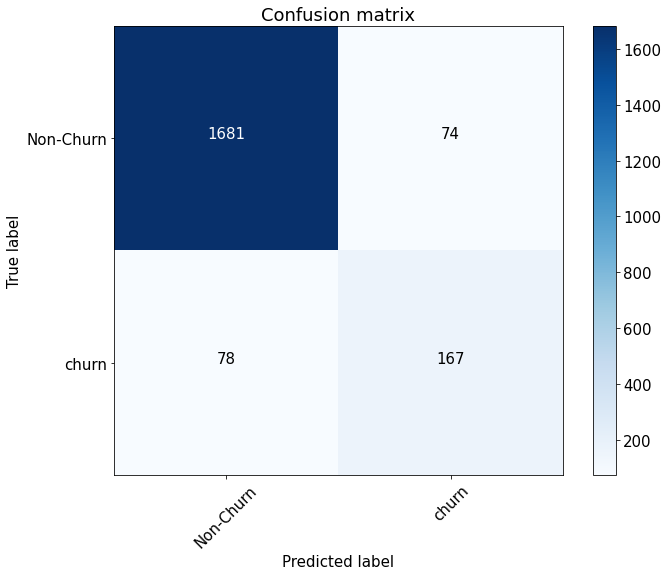

In [39]:
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Non-Churn', 'churn'],
                      title='Confusion matrix')
plt.show()

In [40]:
roc_auc_score(y_test, preds)

0.9501645444502587

2) Модифицировать код функции get_user_embedding таким образом, чтобы считалось не среднее (как в примере np.mean), а медиана. Применить такое преобразование к данным, обучить модель прогнозирования оттока и посчитать метрики качества и сохранить их: roc auc, precision/recall/f_score (для 3 последних - подобрать оптимальный порог с помощью precision_recall_curve, как это делалось на уроке)

In [41]:
def get_user_embedding(user_articles_list):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    user_vector = np.median(user_vector, 0)
    return user_vector

In [42]:
get_user_embedding(user_articles_list)

array([0.06083287, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.039515  , 0.        , 0.        , 0.10092656,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.03325135, 0.        ,
       0.2643807 , 0.01829851, 0.        , 0.        , 0.        ])

In [43]:
user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding(x), 1)])
user_embeddings.columns = ['topic_{}'.format(i) for i in range(25)]
user_embeddings['uid'] = users['uid'].values
user_embeddings = user_embeddings[['uid']+['topic_{}'.format(i) for i in range(25)]]
user_embeddings.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,u105138,0.000000,0.052327,0.000000,0.000000,0.0,0.0,0.022896,0.016337,0.0,...,0.000000,0.0,0.0,0.000000,0.0,0.149841,0.000000,0.0,0.049385,0.106996
1,u108690,0.037325,0.000000,0.000000,0.014655,0.0,0.0,0.032155,0.007390,0.0,...,0.008208,0.0,0.0,0.049916,0.0,0.141852,0.129541,0.0,0.000000,0.079262
2,u108339,0.020273,0.018580,0.007936,0.018605,0.0,0.0,0.012200,0.000000,0.0,...,0.040474,0.0,0.0,0.020818,0.0,0.145020,0.193290,0.0,0.007468,0.092707


In [44]:
X = pd.merge(user_embeddings, target, 'left')
X.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24,churn
0,u105138,0.000000,0.052327,0.000000,0.000000,0.0,0.0,0.022896,0.016337,0.0,...,0.0,0.0,0.000000,0.0,0.149841,0.000000,0.0,0.049385,0.106996,0
1,u108690,0.037325,0.000000,0.000000,0.014655,0.0,0.0,0.032155,0.007390,0.0,...,0.0,0.0,0.049916,0.0,0.141852,0.129541,0.0,0.000000,0.079262,1
2,u108339,0.020273,0.018580,0.007936,0.018605,0.0,0.0,0.012200,0.000000,0.0,...,0.0,0.0,0.020818,0.0,0.145020,0.193290,0.0,0.007468,0.092707,1


In [45]:
X_train, X_test, y_train, y_test = train_test_split(X[['topic_{}'.format(i) for i in range(25)]], 
                                                    X['churn'], random_state=0)

In [46]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

LogisticRegression()

In [47]:
preds = logreg.predict_proba(X_test)[:, 1]
preds[:10]

array([0.07227203, 0.04224947, 0.24320453, 0.68272848, 0.03780208,
       0.14797346, 0.16079201, 0.00710018, 0.05887874, 0.05231135])

In [48]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall + 0.0000000001)

ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.274789, F-Score=0.772, Precision=0.722, Recall=0.829


Confusion matrix, without normalization
[[1677   78]
 [  43  202]]


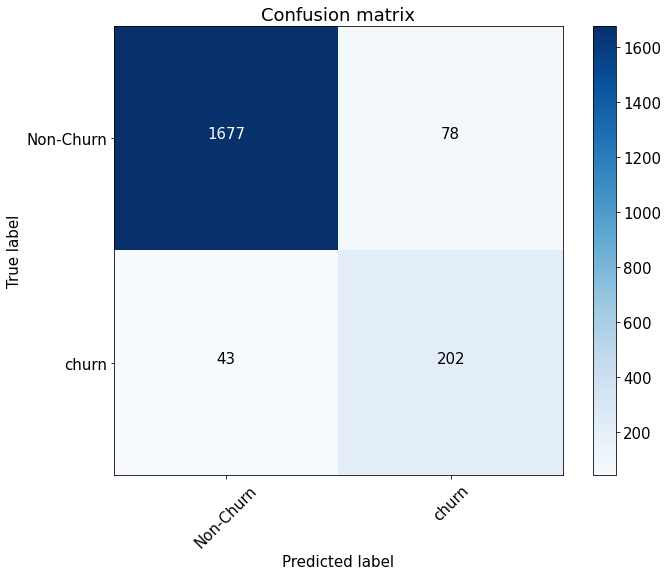

In [50]:
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Non-Churn', 'churn'],
                      title='Confusion matrix')

plt.show()

In [51]:
roc_auc_score(y_test, preds)

0.9707448107448107

3) Повторить п.2, но используя уже не медиану, а max

In [52]:
def get_user_embedding(user_articles_list):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    user_vector = np.max(user_vector, 0)
    return user_vector

In [53]:
get_user_embedding(user_articles_list)

array([0.12004735, 0.01349504, 0.0455586 , 0.13644587, 0.06176907,
       0.        , 0.2816999 , 0.08452176, 0.        , 0.23663729,
       0.01604483, 0.08724453, 0.01557504, 0.        , 0.32282487,
       0.23107742, 0.        , 0.04880518, 0.15901603, 0.02244063,
       0.5081358 , 0.2142693 , 0.01293611, 0.01991852, 0.30525702])

In [54]:
user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding(x), 1)])
user_embeddings.columns = ['topic_{}'.format(i) for i in range(25)]
user_embeddings['uid'] = users['uid'].values
user_embeddings = user_embeddings[['uid']+['topic_{}'.format(i) for i in range(25)]]
user_embeddings.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,u105138,0.039935,0.234022,0.069249,0.000000,0.095940,0.036888,0.210851,0.134923,0.152304,...,0.074951,0.000000,0.000000,0.301652,0.0,0.268594,0.204460,0.0,0.171865,0.342552
1,u108690,0.096302,0.013629,0.058550,0.123506,0.000000,0.018416,0.415328,0.114135,0.022266,...,0.266842,0.000000,0.013035,0.361421,0.0,0.198311,0.198907,0.0,0.044549,0.149580
2,u108339,0.527569,0.100190,0.023953,0.032183,0.045847,0.028566,0.208304,0.034371,0.000000,...,0.190791,0.010112,0.020641,0.051435,0.0,0.231242,0.317060,0.0,0.026788,0.240531


In [55]:
X = pd.merge(user_embeddings, target, 'left')
X.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24,churn
0,u105138,0.039935,0.234022,0.069249,0.000000,0.095940,0.036888,0.210851,0.134923,0.152304,...,0.000000,0.000000,0.301652,0.0,0.268594,0.204460,0.0,0.171865,0.342552,0
1,u108690,0.096302,0.013629,0.058550,0.123506,0.000000,0.018416,0.415328,0.114135,0.022266,...,0.000000,0.013035,0.361421,0.0,0.198311,0.198907,0.0,0.044549,0.149580,1
2,u108339,0.527569,0.100190,0.023953,0.032183,0.045847,0.028566,0.208304,0.034371,0.000000,...,0.010112,0.020641,0.051435,0.0,0.231242,0.317060,0.0,0.026788,0.240531,1


In [56]:
X_train, X_test, y_train, y_test = train_test_split(X[['topic_{}'.format(i) for i in range(25)]], 
                                                    X['churn'], random_state=0)

In [57]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

LogisticRegression()

In [58]:
preds = logreg.predict_proba(X_test)[:, 1]
preds[:10]

array([0.04351022, 0.01881042, 0.64731029, 0.29388176, 0.00756038,
       0.0295585 , 0.0824135 , 0.01847471, 0.01964006, 0.03815737])

In [59]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall + 0.0000000001)
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.360369, F-Score=0.804, Precision=0.804, Recall=0.804


Confusion matrix, without normalization
[[1707   48]
 [  49  196]]


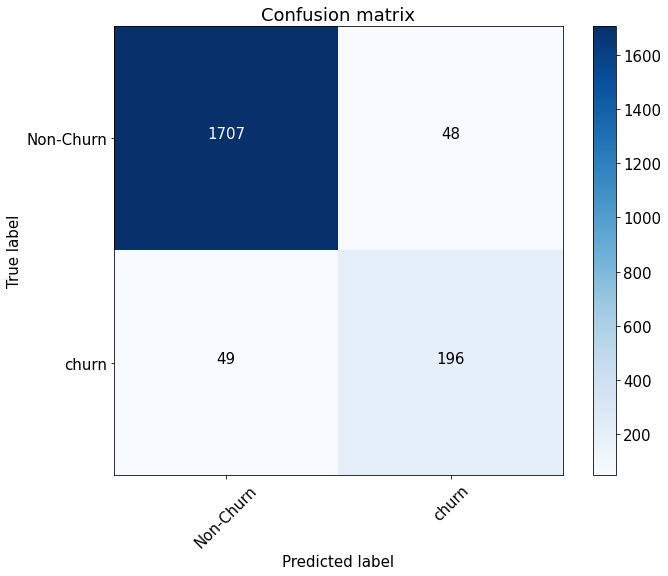

In [60]:
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Non-Churn', 'churn'],
                      title='Confusion matrix')

plt.show()

In [61]:
roc_auc_score(y_test, preds)

0.974826443397872

5) Сформировать на выходе единую таблицу, сравнивающую качество 3 разных метода получения эмбедингов пользователей: mean, median, max, idf_mean по метрикам roc_auc, precision, recall, f_score

In [62]:
df = pd.DataFrame(columns=['model', 'roc_auc', 'precision', 'f_score'])
df

,model,roc_auc,precision,f_score


In [63]:
def get_user_embedding(user_articles_list):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    user_vector = np.mean(user_vector, 0)
    return user_vector

get_user_embedding(user_articles_list)

user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding(x), 1)])
user_embeddings.columns = ['topic_{}'.format(i) for i in range(25)]
user_embeddings['uid'] = users['uid'].values
user_embeddings = user_embeddings[['uid']+['topic_{}'.format(i) for i in range(25)]]

X = pd.merge(user_embeddings, target, 'left')

X_train, X_test, y_train, y_test = train_test_split(X[['topic_{}'.format(i) for i in range(25)]], 
                                                X['churn'], random_state=0)

logreg = LogisticRegression()
logreg.fit(X_train, y_train)

#для тестовой выборки
preds = logreg.predict_proba(X_test)[:, 1]

precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall + 0.0000000001)

ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))
roc_auc = roc_auc_score(y_test, preds)

df = df.append({'model': 'mean', 'roc_auc': roc_auc, 'precision': precision[ix], 'f_score': fscore[ix]}, ignore_index=True)
df

Best Threshold=0.291391, F-Score=0.690, Precision=0.694, Recall=0.686


/var/folders/r0/bf13jj710857v4v0ckcfb8vc0000gp/T/ipykernel_96123/1188384129.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'model': 'mean', 'roc_auc': roc_auc, 'precision': precision[ix], 'f_score': fscore[ix]}, ignore_index=True)


,model,roc_auc,precision,f_score
0,mean,0.950165,0.694215,0.689938


In [64]:
def get_user_embedding(user_articles_list):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    user_vector = np.median(user_vector, 0)
    return user_vector

get_user_embedding(user_articles_list)

user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding(x), 1)])
user_embeddings.columns = ['topic_{}'.format(i) for i in range(25)]
user_embeddings['uid'] = users['uid'].values
user_embeddings = user_embeddings[['uid']+['topic_{}'.format(i) for i in range(25)]]

X = pd.merge(user_embeddings, target, 'left')

X_train, X_test, y_train, y_test = train_test_split(X[['topic_{}'.format(i) for i in range(25)]], 
                                                X['churn'], random_state=0)

logreg = LogisticRegression() 
logreg.fit(X_train, y_train)

preds = logreg.predict_proba(X_test)[:, 1]

precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall + 0.0000000001)

ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))
roc_auc = roc_auc_score(y_test, preds)

df = df.append({'model': 'median', 'roc_auc': roc_auc, 'precision': precision[ix], 'f_score': fscore[ix]}, ignore_index=True)
df

Best Threshold=0.274789, F-Score=0.772, Precision=0.722, Recall=0.829


/var/folders/r0/bf13jj710857v4v0ckcfb8vc0000gp/T/ipykernel_96123/3561576234.py:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'model': 'median', 'roc_auc': roc_auc, 'precision': precision[ix], 'f_score': fscore[ix]}, ignore_index=True)


,model,roc_auc,precision,f_score
0,mean,0.950165,0.694215,0.689938
1,median,0.970745,0.72242,0.771863


In [65]:
def get_user_embedding(user_articles_list):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    user_vector = np.max(user_vector, 0)
    return user_vector

get_user_embedding(user_articles_list)

user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding(x), 1)])
user_embeddings.columns = ['topic_{}'.format(i) for i in range(25)]
user_embeddings['uid'] = users['uid'].values
user_embeddings = user_embeddings[['uid']+['topic_{}'.format(i) for i in range(25)]]

X = pd.merge(user_embeddings, target, 'left')

X_train, X_test, y_train, y_test = train_test_split(X[['topic_{}'.format(i) for i in range(25)]], 
                                                X['churn'], random_state=0)

logreg = LogisticRegression()
logreg.fit(X_train, y_train)

preds = logreg.predict_proba(X_test)[:, 1]

precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall + 0.0000000001)
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))
roc_auc = roc_auc_score(y_test, preds)

df = df.append({'model': 'max', 'roc_auc': roc_auc, 'precision': precision[ix], 'f_score': fscore[ix]}, ignore_index=True)
df

Best Threshold=0.360369, F-Score=0.804, Precision=0.804, Recall=0.804


/var/folders/r0/bf13jj710857v4v0ckcfb8vc0000gp/T/ipykernel_96123/1123687146.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'model': 'max', 'roc_auc': roc_auc, 'precision': precision[ix], 'f_score': fscore[ix]}, ignore_index=True)


,model,roc_auc,precision,f_score
0,mean,0.950165,0.694215,0.689938
1,median,0.970745,0.72242,0.771863
2,max,0.974826,0.804082,0.804082


In [66]:
df

,model,roc_auc,precision,f_score
0,mean,0.950165,0.694215,0.689938
1,median,0.970745,0.72242,0.771863
2,max,0.974826,0.804082,0.804082
